# Nuclei Segmentation

In [93]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 25, 7
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

#### Load input image

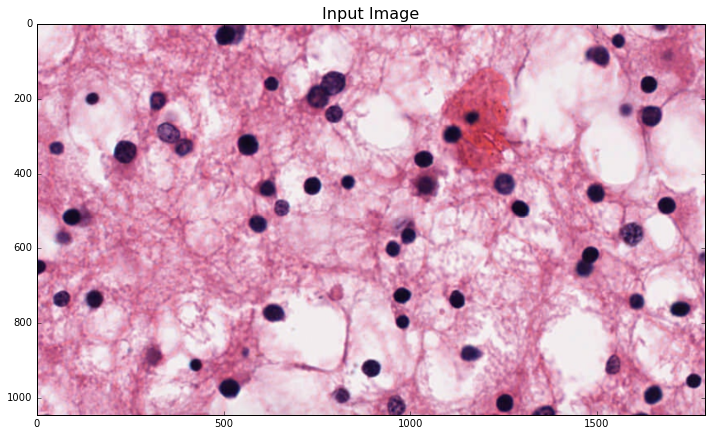

In [99]:
inputImageFile = 'example_data/Easy1.png'

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

#### Perform color normalization

In [95]:
# transform input image to LAB color space
imInputLAB = htk.RudermanLABFwd(imInput)

# compute mean and stddev of input in LAB color space
Mu = np.zeros(3)
Sigma = np.zeros(3)

for i in range(3):
    Mu[i] = imInputLAB[:, :, i].mean()
    Sigma[i] = (imInputLAB[:, :, i] - Mu[i]).std()

# perform reinhard normalization
imNmzd = htk.ReinhardNorm(imInput, Mu, Sigma)

#### Perform color deconvolution

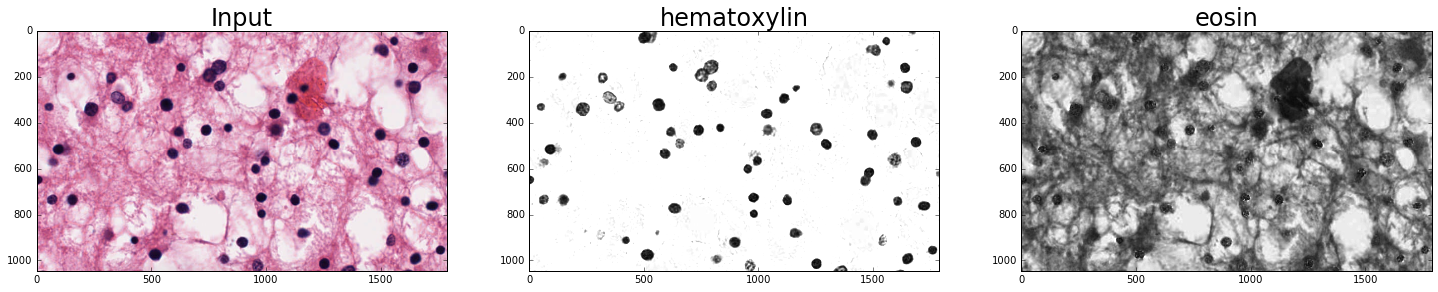

In [96]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1], 
              stainColorMap[stain_2], 
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
imDeconvolved = htk.ColorDeconvolution(imNmzd, W)

# get nuclei/hematoxylin channel
imNucleiStain = imDeconvolved.Stains[:, :, 0].astype(np.float)

# Display results
plt.figure()

plt.subplot(1, 3, 1)
plt.imshow(imInput)
plt.title('Input', fontsize=titlesize)

plt.subplot(1, 3, 2)
plt.imshow(imDeconvolved.Stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 3, 3)
plt.imshow(imDeconvolved.Stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

#### Segment Nuclei

Number of nuclei =  66


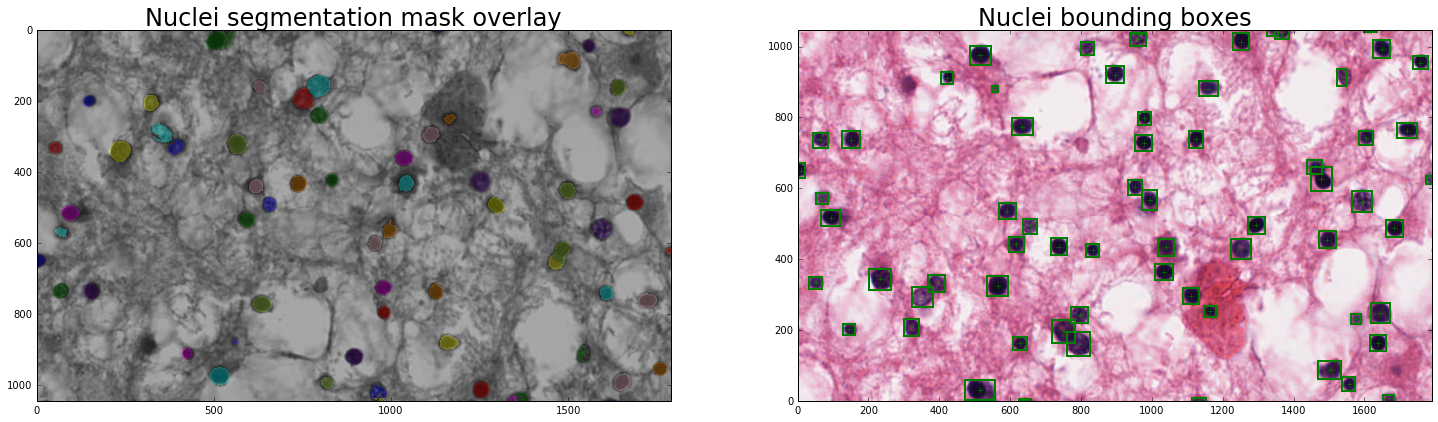

In [100]:
# segment foreground
foreground_threshold = 160

imFgndMask = sp.ndimage.morphology.binary_fill_holes(
    imNucleiStain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

imLog = htk.cLoG(imNucleiStain, imFgndMask,
                 SigmaMin=min_radius * np.sqrt(2),
                 SigmaMax=max_radius * np.sqrt(2))

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

imNucleiSegMask, Seeds, Max = htk.MaxClustering(
    imLog, imFgndMask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

imNucleiSegMask = htk.FilterLabel(
    imNucleiSegMask, Lower=min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(imNucleiSegMask)

print 'Number of nuclei = ', len(objProps)

# Display results
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(imNucleiSegMask, imInput, bg_label=0))
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( imInput )
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] , 
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)